# Player/Ball Detection

This notebook contains code to visualize results of the player/ball detector models.

### SoccerNet Tracking Frames Pretraining Results
We first performed pretraining for our detectors on a dataset of SoccerNet tracking frames (~2.5k images, 2k train + 500 val). <br>
Lets visualize some of the images from this dataset:

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
def convert_yolo_coordinates_to_voc(x_c_n, y_c_n, width_n, height_n, img_width, img_height):
  ## remove normalization given the size of the image
  x_c = float(x_c_n) * img_width
  y_c = float(y_c_n) * img_height
  width = float(width_n) * img_width
  height = float(height_n) * img_height
  ## compute half width and half height
  half_width = width / 2
  half_height = height / 2
  ## compute left, top, right, bottom
  left = int(x_c - half_width) + 1
  top = int(y_c - half_height) + 1
  right = int(x_c + half_width) + 1
  bottom = int(y_c + half_height) + 1
  return left, top, right, bottom

In [3]:
def drawGT(frame, classId, left, top, right, bottom):
    # Draw a bounding box.
    frame_gt = frame
    clsname = 'ball' if classId == '1' else 'player'
    color = (113, 245, 190) if classId == '1' else (255, 178, 50)
    cv2.rectangle(frame_gt, (left, top), (right, bottom), color, 3)
        
    # Get the label for the class name and its confidence
    label = '%s' % (clsname)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    frame_gt = cv2.rectangle(frame_gt, (left, int(top - round(1.5*labelSize[1]))), (left + int(round(1.5*labelSize[0])), top + baseLine), (255, 255, 255), cv2.FILLED)
    frame_gt = cv2.putText(frame_gt, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)
    return frame_gt

In [4]:
IMAGE_PATH = './downloads/trackletframes-2.5k/images/val'
LABEL_PATH = './downloads/trackletframes-2.5k/labels/val'

In [5]:
images, gt_labels = [], []
for img_name in os.listdir(IMAGE_PATH):
    img_base_name = img_name.replace('.jpg', '')
    label_name = img_base_name + '.txt'
    images.append(os.path.join(IMAGE_PATH, img_name))
    gt_labels.append(os.path.join(LABEL_PATH, label_name))

#print(images)
#print(gt_labels)

In [6]:
len(images), len(gt_labels)

(500, 500)

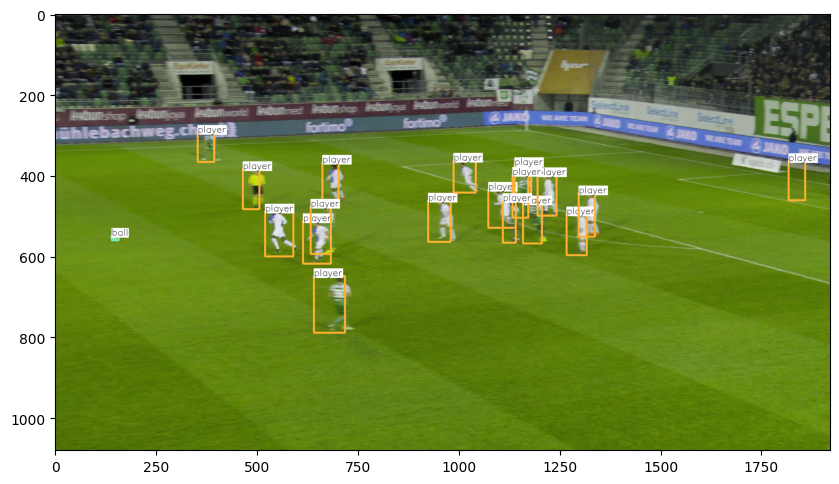

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
i = np.random.choice(len(images))
img = images[i]
frame = cv2.imread(img)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
with open(gt_labels[i], 'r') as f:
    lines = f.readlines()
    for line in lines:
        cls, x_c_n, y_c_n, w_n, h_n = line.split()
        l, t, r, b = convert_yolo_coordinates_to_voc(x_c_n, y_c_n, w_n, h_n, 1920, 1080)
        frame = drawGT(frame, cls, l, t, r, b)
ax.imshow(frame)
            

#### Yolov8 Detection Results

In [10]:
### Load Yolov8
import torch
from ultralytics import YOLO

Yolov8Detector = YOLO('runs/detect/yolov8l_trackletframes-2.5k_fixed_res_1080/weights/best.pt')
Yolov8Detector.val(imgsz=1080)

WARNING ⚠️ imgsz=[1080] must be multiple of max stride 32, updating to [1088]
Ultralytics YOLOv8.0.92 🚀 Python-3.7.12 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 14910MiB)
YOLOv8l summary (fused): 268 layers, 43608150 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /home/sn3007/FootballPassPrediction/downloads/trackletframes-2.5k/labels/val.cache... 500 images, 0 backgr
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:45<
                   all        500       8595      0.834      0.738      0.743      0.447
                Player        500       8108      0.953      0.969      0.983      0.682
              Football        500        487      0.714      0.507      0.503      0.212
Speed: 0.5ms preprocess, 59.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val8


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f99c89dda90>
fitness: 0.4764771587106764
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.68207,     0.21165])
names: {0: 'Player', 1: 'Football'}
plot: True
results_dict: {'metrics/precision(B)': 0.8336997267578633, 'metrics/recall(B)': 0.7381765569331479, 'metrics/mAP50(B)': 0.7430454262393218, 'metrics/mAP50-95(B)': 0.44685846231860465, 'fitness': 0.4764771587106764}
save_dir: PosixPath('runs/detect/val8')
speed: {'preprocess': 0.5459203720092773, 'inference': 59.34291458129883, 'loss': 0.000782012939453125, 'postprocess': 1.436938762664795}

In [11]:
img = images[i]
results = Yolov8Detector.predict(source=img, device=0)


image 1/1 /home/sn3007/FootballPassPrediction/downloads/trackletframes-2.5k/images/val/SNMOT-074_000646.jpg: 640x1088 22 Players, 1 Football, 94.2ms
Speed: 5.8ms preprocess, 94.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1088, 1088)


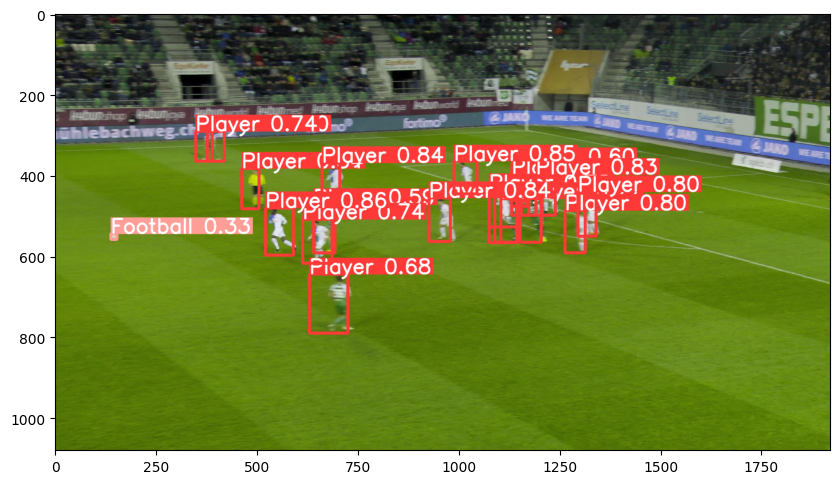

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
res_plotted = results[0].plot()
ax.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.show()